In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# dataset preparation
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))])
train_data = datasets.MNIST('./data', train=True, download=True, transform=tf)
test_data = datasets.MNIST('./data', train=False, download=True, transform=tf)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True)

In [ ]:
# simple fgsm attack
def fgsm(model, loss_fn, images, labels, eps, device):
  images = images.to(device)
  labels = labels.to(device)
  images.requires_grad = True
  pred, pred_probs = model(images)
  model.zero_grad()

  loss = loss_fn(pred, labels).to(device)
  loss.backward()

  adv_images = images + eps * images.grad.sign()
  adv_images = torch.clamp(adv_images, -1, 1)

  return adv_images

In [ ]:
#measuring model accuracy on adv examples
def run_fgsm(model, test_loader, loss_fn, eps, device):
  num_correct = 0

  model.eval()

  for X, y_true in test_loader:
    pert_data = fgsm(model, loss_fn, X, y_true, eps, device)
    y_hat_fgsm, y_hat_probs_fgsm = model(pert_data)
    fgsm_labels = torch.argmax(y_hat_probs_fgsm, 1)

    num_correct += (fgsm_labels == y_true.to(device)).sum()

  model_accuracy = num_correct / len(test_loader.dataset)

  return model, model_accuracy

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
    self.subs1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.subs2 = nn.MaxPool2d(2)
    self.dr1 = nn.Dropout(0.5)
    self.fc1= nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.dr2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(84, 10)

  def deep_features(self, x):
    x = F.relu(self.conv1(x))
    x = self.subs1(x)
    x = F.relu(self.conv2(x))
    x = self.subs2(x)
    x = self.dr1(x)
    x = x.view(-1, np.prod(x.size()[1:]))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dr2(x)
    return x


  def forward(self, x):
    x = self.deep_features(x)
    logits = self.fc3(x)
    probabilities = F.softmax(logits, dim=1)
    return logits, probabilities


In [ ]:
model = LeNet().to(device)
model.load_state_dict(torch.load('LeNetDrout.pt'))

<All keys matched successfully>

In [ ]:
model, fgsm_accuracy = run_fgsm(model, test_loader, loss_fn, 0.3, device)
print(f'Accuracy on fgsm test: {fgsm_accuracy * 100:.2f}%')

Accuracy on fgsm test: 40.94%


In [ ]:
def save_data_for_detection(model, train_loader, test_loader, loss_fn, eps, device):
  X_train = torch.empty((0, 1, 28, 28))
  X_train_deep_features = torch.empty((0, 84))
  X_train_deep_features = X_train_deep_features.to(device)
  X_adv = torch.empty((0, 1, 28, 28))
  X_adv_deep_features = torch.empty((0, 84))
  X_adv_deep_features = X_adv_deep_features.to(device)
  X_test = torch.empty((0, 1, 28, 28))
  X_test_deep_features = torch.empty((0, 84))
  X_test_deep_features = X_test_deep_features.to(device)
  X_train = X_train.to(device)
  X_adv = X_adv.to(device)
  X_test = X_test.to(device)
  y_train = torch.empty(0)
  y_train = y_train.to(device)
  y_test = torch.empty(0)
  y_test = y_test.to(device)
  y_adv = torch.empty(0)
  y_adv = y_adv.to(device)

  model.eval()

  for X, y_true in train_loader:
    X = X.to(device)
    y_true = y_true.to(device)
    X_train = torch.cat((X_train, X))
    X_train_deep_features = torch.cat((X_train_deep_features, model.deep_features(X)))
    y_hat, y_hat_probs = model(X)
    y_train = torch.cat((y_train, y_hat_probs))

  for X, y_true in test_loader:
    pert_data = fgsm(model, loss_fn, X, y_true, eps, device)
    X = X.to(device)
    y_true = y_true.to(device)
    y_hat, y_hat_probs = model(X)

    pred_labels = torch.argmax(y_hat_probs, 1)
    inds_correct = np.where(pred_labels.cpu() == y_true.cpu())
    X = X[inds_correct]
    pert_data = pert_data[inds_correct]
    
    X_adv = torch.cat((X_adv, pert_data))
    X_adv_deep_features = torch.cat((X_adv_deep_features, model.deep_features(pert_data)))
    __, y_pert = model(pert_data)
    y_adv = torch.cat((y_adv, y_pert))
    X_test = torch.cat((X_test, X))
    X_test_deep_features = torch.cat((X_test_deep_features, model.deep_features(X)))
    y_test = torch.cat((y_test, y_hat_probs[inds_correct]))

  return X_train, X_test, X_adv, X_train_deep_features, X_test_deep_features, X_adv_deep_features, y_train, y_test, y_adv


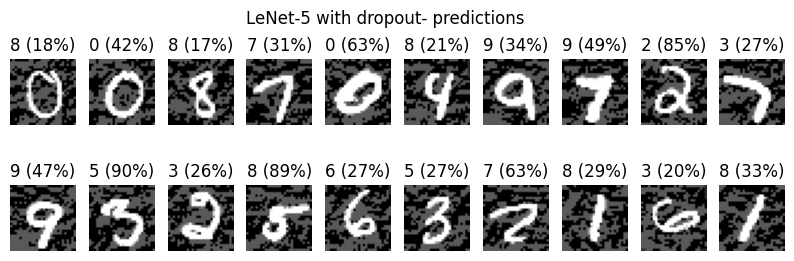

In [ ]:
n_cols = 10
n_rows = 2

X_train, X_test, X_adv, X_train_df, X_test_df, X_adv_df, y_train, y_test, y_adv = save_data_for_detection(model, train_loader, test_loader, loss_fn, 0.3, device)

fig = plt.figure(figsize=(10, 3))
for index in range(1, n_cols * n_rows + 1):
    plt.subplot(n_rows, n_cols, index)
    plt.axis('off')
    plt.imshow(X_adv[index][0].cpu().detach().numpy(), cmap='gray')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(X_adv[index].unsqueeze(0).to(device))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=12)
fig.suptitle('LeNet-5 with dropout- predictions');

In [ ]:
X_adv.shape

torch.Size([9895, 1, 28, 28])

In [ ]:
y_train_labels = y_train.argmax(dim=1).cpu()
y_test_labels = y_test.argmax(dim=1).cpu()
y_adv_labels = y_adv.argmax(dim=1).cpu()

In [ ]:
from sklearn.neighbors import KernelDensity

class_indices = {}
kdes = {}

for i in range(y_train.shape[1]):
  class_indices[i] = np.where(y_train_labels == i)

for i in range(y_train.shape[1]):
  kdes[i] = KernelDensity(kernel='gaussian', bandwidth=1.20).fit(X_train_df[class_indices[i]].cpu().detach().numpy())

In [ ]:
kdes[0]

KernelDensity(bandwidth=1.2)

In [ ]:
def score_densities(features, labels, kdes):
  densities = np.empty(0)
  for i in range(labels.shape[0]):
    class_label = labels[i].item()
    densities = np.concatenate((densities, kdes[class_label].score_samples(features[i].reshape((1, -1)).cpu().detach().numpy())))
  
  return densities

In [ ]:
clean_densities = score_densities(X_test_df, y_test_labels, kdes)
adv_densities = score_densities(X_adv_df, y_adv_labels, kdes)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

def train_detector(densities_neg, densities_pos):
  values_neg = densities_neg.reshape(1, -1).transpose()
  values_pos = densities_pos.reshape(1, -1).transpose()

  values = np.concatenate((values_neg, values_pos))
  labels = np.concatenate((np.zeros_like(densities_neg), np.ones_like(densities_pos)))

  lr = LogisticRegressionCV().fit(values,labels)
  return values, labels, lr

In [ ]:
values, labels, detector = train_detector(clean_densities, adv_densities)

In [ ]:
probabilities = detector.predict_proba(values)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, auc

def compute_roc(probs_neg, probs_pos, plot=False):
    """
    TODO
    :param probs_neg:
    :param probs_pos:
    :param plot:
    :return:
    """
    probs = np.concatenate((probs_neg, probs_pos))
    labels = np.concatenate((np.zeros_like(probs_neg), np.ones_like(probs_pos)))
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score

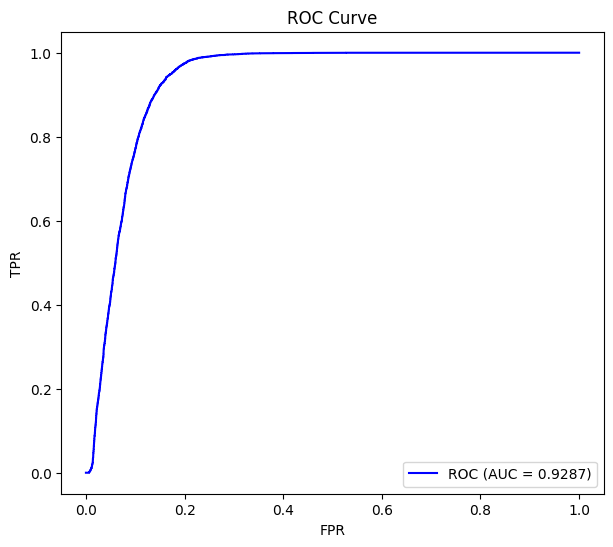

In [ ]:
_, _, auc_score = compute_roc(probabilities[:len(X_test)], probabilities[len(X_test):], plot=True)

In [ ]:
print('Detector ROC-AUC score: %0.4f' % auc_score)

Detector ROC-AUC score: 0.9287


In [ ]:
probabilities

array([0.03527354, 0.03659276, 0.02402826, ..., 0.60798231, 0.63430898,
       0.77186543])